In [1]:
import glob, os
test_data_files = []
for file in glob.glob("/Users/mohamedr/projects/rules/nmt_scalp_eeg_dataset/*/eval/*.edf"):
    test_data_files.append(file)
print(len(test_data_files))

train_data_files = []
for file in glob.glob("/Users/mohamedr/projects/rules/nmt_scalp_eeg_dataset/*/train/*.edf"):
    train_data_files.append(file)
print(len(train_data_files))

185
2232


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import mne
import numpy as np

data = mne.io.read_raw(file, verbose=False, preload=True)

data.filter(l_freq=0.5, h_freq=47, verbose=False)
#data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
data = data.get_data()#*1e6
data.shape

(21, 169200)

In [241]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter
from scipy import signal
import cv2
from numpy import *
from scipy.stats import iqr
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.stats import differential_entropy, norm
from scipy import fftpack
import antropy as ant

def calcGrangerCausality(eegData,ii,jj):
    eegData = np.diff(eegData)
    X = np.vstack([eegData[ii,:],eegData[jj,:]]).T
    gc = grangercausalitytests(X, 1, addconst=True, verbose=False)[1][0]['ssr_ftest'][0]
    return gc
    
def get_label(file):
    label = file.split("/")[-3]
    if label == "normal":
        return [0]
    elif label == "abnormal":
        return [1]

    
def lyapunov(x):
    return np.mean(np.log(np.abs(np.gradient(x))))


def build_data(raw_data, bands=False):
    
    eeg_data = []
    labels = []
    lengths = []
    groups = []
    i = 0
    fs = 100
    
    data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        #get label
        label = get_label(file)
        data_labels.append(label)
        
        #node features
        sample_features = []
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=40, verbose=False)
        #data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
        data = data.get_data()*1e6
          
        #gc = []
        #for i in range(21):
        #    gc1 = []
        #    for j in range(21):
        #        gc1.append(calcGrangerCausality(data, i, j))
        #    gc.append(gc1)
        #data_graphs.append(gc)    
        
        
        ch_features = []    
        # freq domain features
        sf = 256
        win = 4 * sf # win size 4 seconds * sampling freq
        # delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–... Hz).
        freq_ranges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 47]]
        for ch in data:
            
            ch_features.append(differential_entropy(ch))
        
            ly = lyapunov(ch)
            ch_features.append(ly)
        
            entropy = ant.perm_entropy(ch, normalize=True)
            ch_features.append(entropy)
        
            entropy = ant.spectral_entropy(ch, sf=100, method='welch', normalize=True)
            ch_features.append(entropy)
        
            mobility = ant.hjorth_params(ch)
            ch_features.append(mobility[0])
            ch_features.append(mobility[1])
        
            zero_cross_count = ant.num_zerocross(ch)
            ch_features.append(zero_cross_count)
            
                
            
            if bands:
                # freq domain features
                for freq_band in freq_ranges:
                
                    # differential entropy
                    sos = signal.butter(10, (freq_band[0], freq_band[1]), 'bandpass', fs=1000, output='sos')
                    filtered_ch = signal.sosfilt(sos, ch) 
                    ch_features.append(differential_entropy(filtered_ch))

                    # lyapunov features
                    ch_features.append(lyapunov(filtered_ch))

                    # Permutation entropy
                    entropy = ant.perm_entropy(filtered_ch, normalize=True)
                    ch_features.append(entropy)

                    # Spectral entropy
                    entropy = ant.spectral_entropy(filtered_ch, sf=100, method='welch', normalize=True)
                    ch_features.append(entropy)

                    # Hjorth mobility and complexity
                    mobility = ant.hjorth_params(filtered_ch)
                    ch_features.append(mobility[0])
                    ch_features.append(mobility[1])

                    corr = np.correlate(filtered_ch, filtered_ch)
                    ch_features.append(corr[0])

                    # Number of zero-crossings
                    zero_cross_count = ant.num_zerocross(filtered_ch)
                    ch_features.append(zero_cross_count)

                    # power spectrum
                    freqs, psd = signal.welch(ch, sf, nperseg=win)
                    idx_freq_band = np.logical_and(freqs >= freq_band[0], freqs < freq_band[1])
                    # Frequency resolution
                    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25
                    # Compute the absolute power by approximating the area under the curve
                    band_power = simps(psd[idx_freq_band], dx=freq_res)
                    #power_band_.append(band_power)
                    ch_features.append(band_power)
                
            
            sample_features.append(ch_features)
            ch_features = []
            
        data_features.append(sample_features)
        
    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    data_graphs = np.array(data_graphs)
    
    return data_features, data_graphs, data_labels

In [242]:
#%%capture
np.random.seed(42)
train_X, train_graphs, train_y = build_data(train_data_files)
test_X, test_graphs, test_y = build_data(test_data_files)

 45%|███████████████████████████▎                                 | 1001/2232 [08:43<09:31,  2.16it/s]/var/folders/jh/bl76wbz94n3727gszxkh079h0000gr/T/ipykernel_69273/4293051823.py:60: RuntimeWarning: filter_length (1321) is longer than the signal (923), distortion is likely. Reduce filter length or filter a longer signal.
  data.filter(l_freq=0.5, h_freq=40, verbose=False)
 86%|████████████████████████████████████████████████████▎        | 1915/2232 [16:44<02:55,  1.81it/s]/var/folders/jh/bl76wbz94n3727gszxkh079h0000gr/T/ipykernel_69273/4293051823.py:60: RuntimeWarning: filter_length (1321) is longer than the signal (738), distortion is likely. Reduce filter length or filter a longer signal.
  data.filter(l_freq=0.5, h_freq=40, verbose=False)
100%|███████████████████████████████████████████████████████████████| 185/185 [01:35<00:00,  1.94it/s]


In [243]:
test_X.shape, train_X.shape, train_graphs.shape, test_y.shape, train_y.shape, test_graphs.shape

((185, 21, 7), (2232, 21, 7), (0,), (185, 1), (2232, 1), (0,))

In [244]:
test_X.min(), train_X.min(), test_X.max(), train_X.max()

(-6.358030789071418, -6.587580262095357, 37322.0, 171520.0)

In [245]:
np.save("conn_data/gc/train_X.npy", train_X)
np.save("conn_data/gc/test_X.npy", test_X)
np.save("conn_data/gc/train_y.npy", train_y)
np.save("conn_data/gc/test_y.npy", test_y)
#np.save("conn_data/gc/train_graphs.npy", train_graphs)
#np.save("conn_data/gc/test_graphs.npy", test_graphs)

In [246]:
train_X = np.load("conn_data/gc/train_X.npy")
test_X = np.load("conn_data/gc/test_X.npy")
train_y = np.load("conn_data/gc/train_y.npy")
test_y = np.load("conn_data/gc/test_y.npy")
train_graphs = np.load("conn_data/gc/train_graphs.npy")
test_graphs = np.load("conn_data/gc/test_graphs.npy")

0


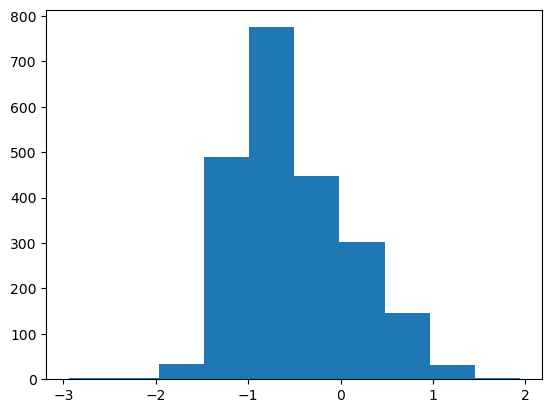

1


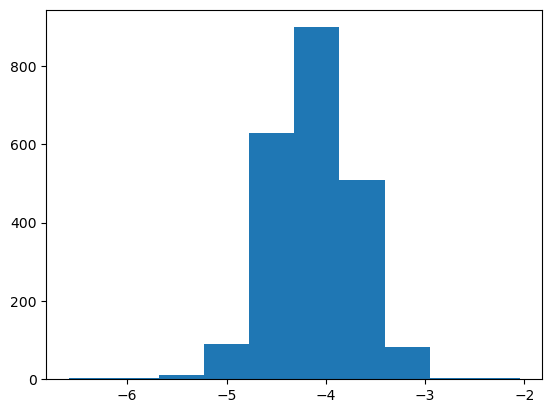

2


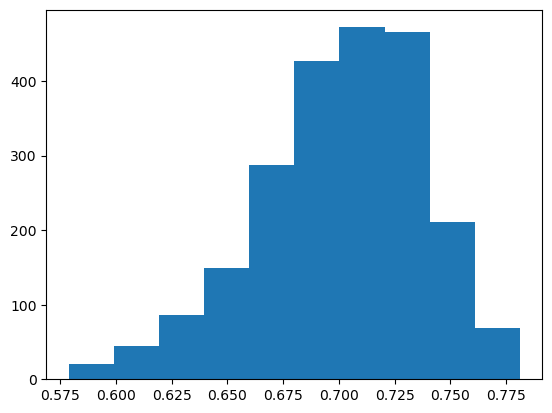

3


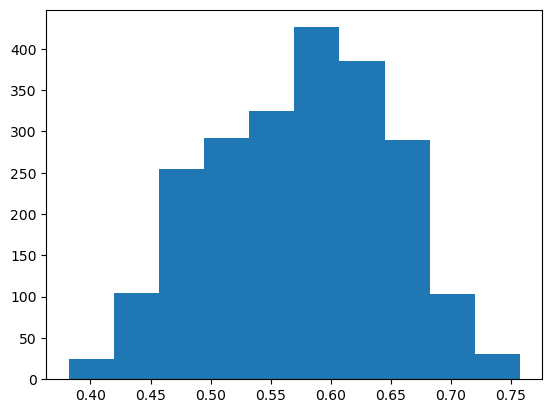

4


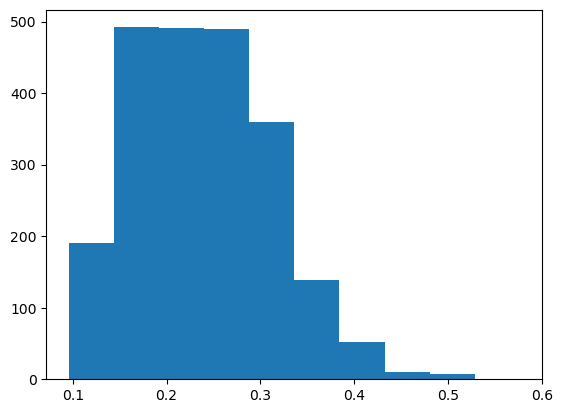

5


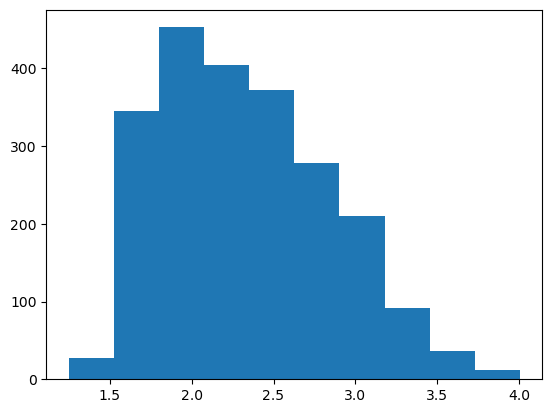

6


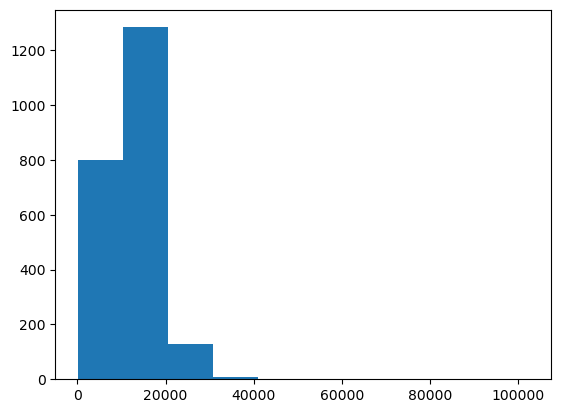

In [51]:
import matplotlib.pyplot as plt
for i in range(7):
    print(i)
    plt.hist(train_X[:, 4, i])
    plt.show()

In [247]:
import torch
import copy

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import copy

def data_loader(features, graphs, labels, device, batch_size, shuffle=True):
    features, graphs, labels = torch.Tensor(features), torch.Tensor(graphs), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

def standardize_data(train_X, test_X):
 
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    
    for i in tqdm(range(train_X.shape[1])):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j])
            max_ = np.max(train_X[:, i, j]) #+ 0.000000000000001
        
            train_X_std[:, i, j] = (train_X[:, i, j] - min_)/(max_ - min_)    
            test_X_std[:, i, j] = (test_X[:, i, j] - min_)/(max_ - min_)

    return train_X_std, test_X_std

In [250]:
train_X.shape, test_X.shape

((2232, 21, 7), (185, 21, 7))

In [251]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(171520.0, 37322.0, -6.587580262095357, -6.358030789071418)

In [252]:
from tqdm import tqdm
train_X, test_X = standardize_data(train_X, test_X)

train_X.shape

100%|███████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1846.05it/s]


(2232, 21, 7)

In [253]:
import copy

def uniform(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test

train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [254]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 1.3026285473939159, 0.0, -0.10262589690892014)

In [255]:
train_graphs.max(), train_graphs.min()

(1.0, 0.0)

In [256]:
test_graphs.max(), test_graphs.min()

(0.5711957353673076, 1.2006028223944977e-15)

In [257]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def evaluate_model(model, loss_func, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            #y = y.long()
            #y = y.float()
            loss = loss_func(y_pred,y)
            loss_sum += loss.item()
            n += 1
        return loss_sum / n
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            yhat = model(x, A)
            
            #yhat = [0 if i<0.5 else 1 for i in yhat]
            #yhat = torch.exp(yhat)
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
        
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    #fpr, tpr, thresholds = roc_curve(ytrue, y_score)
    #auc_measure = auc(fpr, tpr)
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds,  average='weighted'), 
            recall_score(ytrue, ypreds,  average='weighted'),
            f1_score(ytrue, ypreds,  average='weighted'))

# GC

In [186]:
import torch
import torch.nn as nn
import torch.nn.functional as F


"""
    LAYERS: GCNConv and ChebNetConv
"""

def normalize_A(A, lmax=2):
    A=F.relu(A)
    N=A.shape[0]
    A=A*(torch.ones(N,N)-torch.eye(N,N))
    A=A+A.T
    d = torch.sum(A, 1)
    d = 1 / torch.sqrt((d + 1e-10))
    D = torch.diag_embed(d)
    L = torch.eye(N,N)-torch.matmul(torch.matmul(D, A), D)
    Lnorm=(2*L/lmax)-torch.eye(N,N)
    #Lnorm=Lnorm*-1
    return Lnorm

def normalize_all_A(A):
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj).detach().numpy())
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A


class GCNConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNConv, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        x = self.linear(x)
        x = torch.matmul(adjacency_hat, x)
        return x


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        x = self.linear(x)
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2

        #cheb_x = cheb_x.reshape([x.shape[0], -1])
        return cheb_x


class TwoLayerGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, dropout=0.1):
        super(TwoLayerGCN, self).__init__()

        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = Linear(336, num_classes)
        
    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        x = self.dropout(x)
        x = self.conv1(x, adjacency_hat)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, adjacency_hat)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_classes, num_hidden_layers=0, dropout=0.1, residual=False):
        super(GCN, self).__init__()

        self.dropout = dropout
        self.residual = residual
        
        self.input_conv = GCNConv(input_size, hidden_size)
        self.hidden_convs = nn.ModuleList([GCNConv(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.output_conv = GCNConv(hidden_size, out_channels)
        self.fc = Linear(168, num_classes)

    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        print("Laplacian: ", adjacency_hat.shape)
        x = F.dropout(x, p=self.dropout, training=self.training)
        print("after dropout: ", x.shape)
        x = F.relu(self.input_conv(x, adjacency_hat))
        print("after input conv: ", x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, adjacency_hat)) + x
            else:
                x = F.relu(conv(x, adjacency_hat))
        print("after conv: ", x.shape)
        x = F.dropout(x, p=self.dropout, training=self.training)
        print("x: ", x.shape, ", adjacency_hat:, ", adjacency_hat.shape)
        x = self.output_conv(x, adjacency_hat)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class TwoLayerChebNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, dropout=0.1, k=2):
        super(TwoLayerChebNet, self).__init__()

        self.conv1 = ChebNetConv(21*input_size, hidden_size, k)
        self.conv2 = ChebNetConv(hidden_size, out_channels, k)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = Linear(21, num_classes)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.dropout(x)
        x = self.conv1(x, laplacian)
        x = self.relu(x)
        x = self.dropout(x)
        #x = self.conv2(x, laplacian)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

from torch_geometric.nn import global_mean_pool

class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_classes, num_hidden_layers=3, dropout=0.1, residual=False, k=1):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        self.BN1 = nn.BatchNorm1d(out_channels)
        self.fc = nn.Linear(out_channels, num_classes)
        
    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        laplacian = normalize_all_A(laplacian)
        #print("laplaician: ", laplacian.shape)
        x = F.dropout(x, p=self.dropout, training=self.training)
        #print("after dropout: ", x.shape)
        x = F.relu(self.input_conv(x, laplacian))
        #print("input conv: ", x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, laplacian)) + x
            else:
                x = F.relu(conv(x, laplacian))
        #print("input conv: ", x.shape)
        x = F.dropout(x, p=self.dropout, training=self.training)
        #print("dropout: ", x.shape, ", laplacian: ",laplacian.shape)
        x = self.output_conv(x, laplacian)
        #print("output conv: ", x.shape)
        x = x.squeeze()
        batch =None
        x = global_mean_pool(x, batch)
        #print("after reshape: ", x.shape)
        x = self.BN1(x)
        x = self.fc(x)
        return x

In [133]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch

NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

#print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    #print("KFold ", i)
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 128, NUM_CHANNELS, 128, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        #print("Epoch", epoch) 
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

  0%|                                                                        | 0/1000 [00:00<?, ?it/s]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|                                                                | 1/1000 [00:01<17:10,  1.03s/it]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


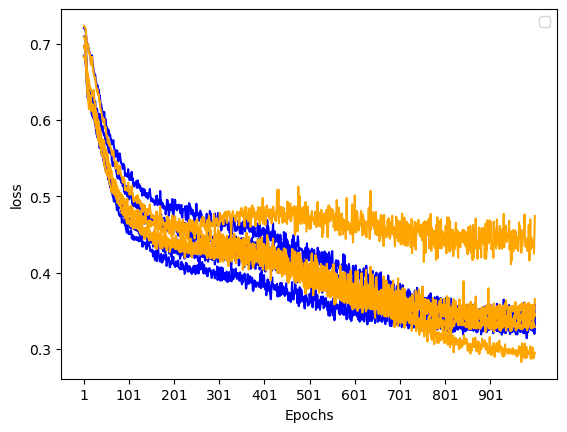

In [165]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


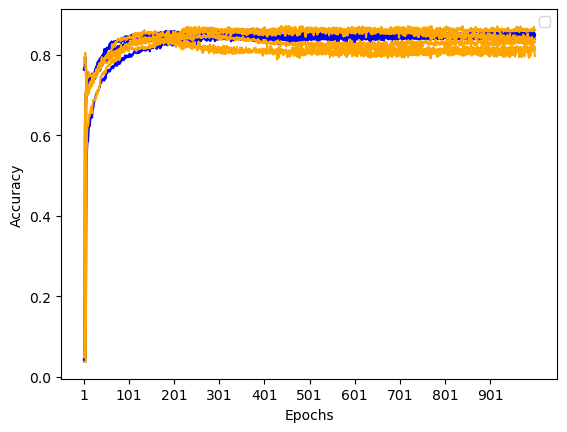

In [135]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.show()

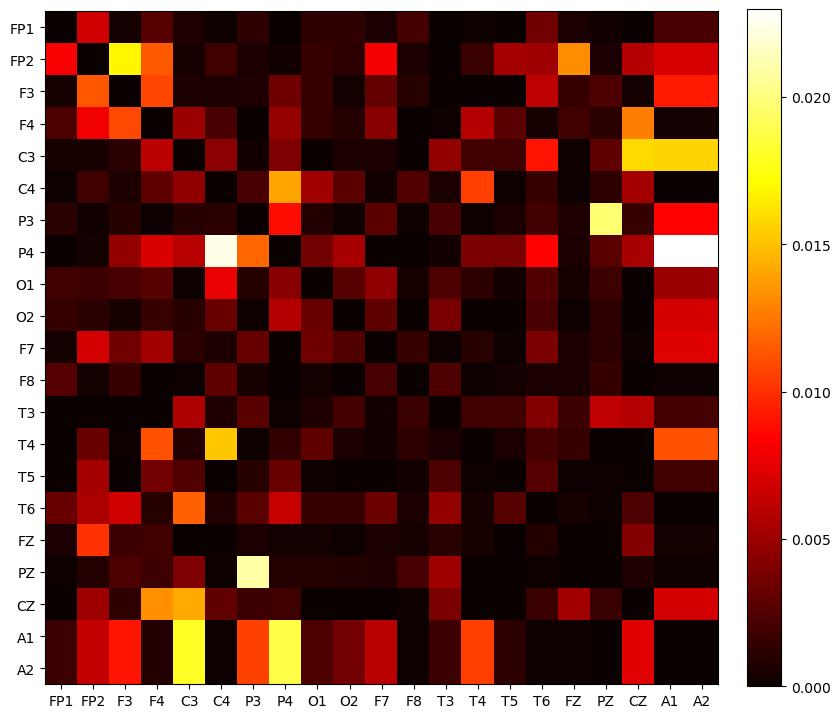

label:  [1]


In [508]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
x = [0.00001,0.001,0.01,0.1,0.5,1,5]
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[20], cmap='hot', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
plt.show()
print("label: ", train_y[20])

In [ ]:
#%%capture
print("Training Model....")
NUM_EPOCHS = 300
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 64, NUM_CHANNELS, 64, NUM_CLASSES)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        #y = y.squeeze()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss#.item()
        loss.backward()
        optimizer.step()
    #train_acc = cal_accuracy(model, train_iter)
    #if train_acc[0] >= 0.82:
    #    print("Early Stopped")
    #    break

Training Model....


 12%|███████▋                                                        | 36/300 [00:15<01:51,  2.37it/s]

In [272]:
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.8624551971326165
Precision:  0.8452884676391561
Recall:  0.8624551971326165
F1:  0.848433671003671
Confusion Matrix:  [[1792   85]
 [ 222  133]]


In [273]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.7351351351351352
Precision:  0.805984555984556
Recall:  0.7351351351351352
F1:  0.7163503929461376
Confusion Matrix:  [[93  2]
 [47 43]]


# Correlation

In [630]:
import numpy as np

def build_graphs(raw_data):
    
    fs = 100
    
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=47, verbose=False)
        #data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
        data = data.get_data()*1e6
          
        data = np.diff(data)    
        #corr = []
        #for i in range(21):
        #    corr1 = []
        #    for j in range(21):
        #        corr1.append(np.correlate(data[i], data[j])[0])
        #    corr.append(corr1)
        
        gc = []
        for i in range(21):
            gc1 = []
            for j in range(21):
                gc1.append(calcGrangerCausality(data, i, j))
            gc.append(gc1)
        data_graphs.append(gc)  
        
        #data_graphs.append(corr)    
        
    data_graphs = np.array(data_graphs)
    
    return data_graphs

In [631]:
train_graphs = build_graphs(train_data_files)
test_graphs = build_graphs(test_data_files)

 45%|███████████████████████████████████▍                                           | 1001/2232 [5:35:40<6:04:12, 17.75s/it]/var/folders/jh/bl76wbz94n3727gszxkh079h0000gr/T/ipykernel_25118/143230868.py:14: RuntimeWarning: filter_length (1321) is longer than the signal (923), distortion is likely. Reduce filter length or filter a longer signal.
  data.filter(l_freq=0.5, h_freq=47, verbose=False)
 86%|██████████████████████████████████████████████████████████████████▉           | 1915/2232 [11:29:56<1:47:59, 20.44s/it]/var/folders/jh/bl76wbz94n3727gszxkh079h0000gr/T/ipykernel_25118/143230868.py:14: RuntimeWarning: filter_length (1321) is longer than the signal (738), distortion is likely. Reduce filter length or filter a longer signal.
  data.filter(l_freq=0.5, h_freq=47, verbose=False)
100%|█████████████████████████████████████████████████████████████████████████████████████| 185/185 [59:32<00:00, 19.31s/it]


In [635]:
np.save("conn_data/gc/train_graphs.npy", train_graphs)
np.save("conn_data/gc/test_graphs.npy", test_graphs)

In [358]:
train_corr_graphs = np.load("conn_data/corr/train_graphs.npy")
test_corr_graphs = np.load("conn_data/corr/test_graphs.npy")

In [359]:
train_corr_graphs, test_corr_graphs = uniform(train_corr_graphs, test_corr_graphs)

In [360]:
train_corr_graphs.shape

(2232, 21, 21)

In [486]:
#%%capture
print("Training Model....")
NUM_EPOCHS = 200
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 51
BATCH_SIZE = 128

model = ChebNetGCN(NUM_NODE_FEATURES, 64, NUM_CHANNELS, 64, NUM_CLASSES)

loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_corr_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_corr_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss#.item()
        loss.backward()
        optimizer.step()

Training Model....


100%|█████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:00<00:00,  3.32it/s]


In [487]:
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.907258064516129
Precision:  0.9061435565802181
Recall:  0.907258064516129
F1:  0.8949716375333167
Confusion Matrix:  [[1857   20]
 [ 187  168]]


In [488]:
train_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.6972972972972973
Precision:  0.7969345184110285
Recall:  0.6972972972972973
F1:  0.6659282233052725
Confusion Matrix:  [[94  1]
 [55 35]]


# Dot Product (GC, Corr)

In [26]:
#train_X = np.load("conn_data/gc/train_X.npy")
#test_X = np.load("conn_data/gc/test_X.npy")
#train_y = np.load("conn_data/gc/train_y.npy")
#test_y = np.load("conn_data/gc/test_y.npy")
#train_graphs = np.load("conn_data/gc/train_graphs.npy")
#test_graphs = np.load("conn_data/gc/test_graphs.npy")
#train_corr_graphs = np.load("conn_data/corr/train_graphs.npy")
#test_corr_graphs = np.load("conn_data/corr/test_graphs.npy")

In [1054]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module

import numpy as np


def normalize_A(A,lmax=2):
    A=F.relu(A)
    N=A.shape[0]
    A=A*(torch.ones(N,N)-torch.eye(N,N))
    A=A+A.T
    d = torch.sum(A, 1)
    d = 1 / torch.sqrt((d + 1e-10))
    D = torch.diag_embed(d)
    L = torch.eye(N,N)-torch.matmul(torch.matmul(D, A), D)
    Lnorm=(2*L/lmax)-torch.eye(N,N)
    return Lnorm

def normalize_all_A(A):
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj).detach().numpy())
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A

def generate_cheby_adj(L, K):
    support = []
    for i in range(K):
        if i == 0:
            support.append(torch.eye(L.shape[-1]))
        elif i == 1:
            support.append(L)
        else:
            temp = torch.matmul(2*L,support[-1],)-support[-2]
            support.append(temp)
    return support

        
import torch
import torch.nn as nn
import torch.nn.functional as F


class Chebynet(nn.Module):
    def __init__(self, in_channels, K, out_channels):
        super(Chebynet, self).__init__()
        self.K = K
        self.gc = nn.ModuleList()
        for i in range(K):
            self.gc.append(GraphConvolution( in_channels,  out_channels))

    def forward(self, x,L):
        adj = generate_cheby_adj(L, self.K)
        for i in range(len(self.gc)):
            if i == 0:
                result = self.gc[i](x, adj[i])
            else:
                result += self.gc[i](x, adj[i])
        result = F.relu(result)
        return result


class DGCNN(nn.Module):
    def __init__(self, in_channels,num_electrodes, k_adj, out_channels, num_classes=3):
        super(DGCNN, self).__init__()
        self.K = k_adj
        self.layer1 = Chebynet(in_channels, k_adj, out_channels)
        self.layer2 = Chebynet(in_channels, k_adj, out_channels)
        self.BN1 = nn.BatchNorm1d(in_channels)
        self.fc = Linear(2*num_electrodes*out_channels, num_classes)

    def forward(self, x, A1, A2):
        #x = self.BN1(x.transpose(1, 2)).transpose(1, 2) #data can also be standardized offline
        L1 = normalize_all_A(A1)
        L2 = normalize_all_A(A2)
        result1 = self.layer1(x, L1)
        result2 = self.layer2(x, L2)
        result1 = result1.reshape(x.shape[0], -1)
        result2 = result2.reshape(x.shape[0], -1)
        result = torch.cat((result1, result2), -1)
        result = self.fc(result)
        return result

In [130]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

import numpy as np


def normalize_A(A,lmax=2):
    A=F.relu(A)
    N=A.shape[0]
    A=A*(torch.ones(N,N)-torch.eye(N,N))
    A=A+A.T
    d = torch.sum(A, 1)
    d = 1 / torch.sqrt((d + 1e-10))
    D = torch.diag_embed(d)
    L = torch.eye(N,N)-torch.matmul(torch.matmul(D, A), D)
    Lnorm=(2*L/lmax)-torch.eye(N,N)
    return Lnorm

def normalize_all_A(A):
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj).detach().numpy())
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A

class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):

        super(GraphConvolution, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        nn.init.xavier_normal_(self.weight)
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_channels))
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = torch.matmul(out, self.weight)
        if self.bias is not None:
            return out + self.bias
        else:
            return out

class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=True):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(torch.zeros(size=(in_features, out_features))))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(torch.zeros(size=(out_features,))))
        else:
            self.register_parameter('bias', None)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        x = x @ self.weight
        if self.bias is not None:
            x += self.bias

        return torch.matmul(adj, x)
        
from torch_geometric.nn import GCNConv


class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        nn.init.xavier_normal_(self.linear.weight)
        if bias:
            nn.init.zeros_(self.linear.bias)

    def forward(self, inputs):
        return self.linear(inputs)
    

import torch
import torch.nn as nn
import torch.nn.functional as F


class GNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GNet, self).__init__()
        self.gc = GCNLayer(in_channels, out_channels)

    def forward(self, x, L):
        result = self.gc(x, L)
        result = F.relu(result)
        return result


class DGCNN(nn.Module):
    def __init__(self, in_channels,num_electrodes, k_adj, out_channels, num_classes=3):
        super(DGCNN, self).__init__()
        self.K = k_adj
        self.layer1 = GNet(in_channels, out_channels)
        self.layer2 = GNet(in_channels, out_channels)
        self.BN1 = nn.BatchNorm1d(in_channels)
        self.fc = Linear(2*num_electrodes*out_channels, num_classes)

    def forward(self, x, A1, A2):
        #x = self.BN1(x.transpose(1, 2)).transpose(1, 2) #data can also be standardized offline
        L1 = normalize_all_A(A1)
        L2 = normalize_all_A(A2)
        result1 = self.layer1(x, L1)
        result2 = self.layer2(x, L2)
        result1 = result1.reshape(x.shape[0], -1)
        result2 = result2.reshape(x.shape[0], -1)
        result = torch.cat((result1, result2), -1)
        result = self.fc(result)
        return result

In [1659]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module

import numpy as np


def normalize_A(A,lmax=2):
    A=F.relu(A)
    N=A.shape[0]
    A=A*(torch.ones(N,N)-torch.eye(N,N))
    A=A+A.T
    d = torch.sum(A, 1)
    d = 1 / torch.sqrt((d + 1e-10))
    D = torch.diag_embed(d)
    L = torch.eye(N,N)-torch.matmul(torch.matmul(D, A), D)
    Lnorm=(2*L/lmax)-torch.eye(N,N)
    return Lnorm

def normalize_all_A(A):
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj).detach().numpy())
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A


class GraphConvolution(nn.Module):
    def __init__(self, in_channels, out_channels, bias=False):

        super(GraphConvolution, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.weight = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        nn.init.xavier_normal_(self.weight)
        self.bias = None
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_channels))
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = torch.matmul(out, self.weight)
        if self.bias is not None:
            return out + self.bias
        else:
            return out

class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        nn.init.xavier_normal_(self.linear.weight)
        if bias:
            nn.init.zeros_(self.linear.bias)

    def forward(self, inputs):
        return self.linear(inputs)
    
    
import torch
import torch.nn as nn
import torch.nn.functional as F


class Chebynet(nn.Module):
    def __init__(self, in_channels, K, out_channels):
        super(Chebynet, self).__init__()
        self.K = K
        self.gc = GraphConvolution( in_channels,  out_channels)

    def forward(self, x,L):
        result = self.gc(x, L)
        result = F.relu(result)
        return result


class DGCNN(nn.Module):
    def __init__(self, in_channels,num_electrodes, out_channels, num_classes=3):
        super(DGCNN, self).__init__()
        self.layer1 = GNet(in_channels, out_channels)
        self.layer2 = GNet(in_channels, out_channels)
        self.BN1 = nn.BatchNorm1d(in_channels)
        self.fc = Linear(2*num_electrodes*out_channels, num_classes)

    def forward(self, x, A1, A2):
        L1 = normalize_all_A(A1)
        L2 = normalize_all_A(A2)
        result1 = self.layer1(x, L1)
        result2 = self.layer2(x, L2)
        result1 = result1.reshape(x.shape[0], -1)
        result2 = result2.reshape(x.shape[0], -1)
        result = torch.cat((result1, result2), -1)
        result = self.fc(result)
        return result

In [1691]:
import torch
import torch.nn as nn
import torch.nn.functional as F


"""
    LAYERS: GCNConv and ChebNetConv
"""


class GCNConv(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNConv, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)

    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        #print(x.shape, adjacency_hat.shape)
        x = self.linear(x)
        x = torch.matmul(adjacency_hat, x)
        return x


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        #print(x.shape)
        x = self.linear(x)
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x

        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2

        cheb_x = cheb_x.reshape([x.shape[0], -1])
        #print(cheb_x.shape)
        return cheb_x


"""
    MODELS
"""


class TwoLayerGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, dropout=0.1):
        super(TwoLayerGCN, self).__init__()

        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = Linear(336, num_classes)
        
    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        x = self.dropout(x)
        x = self.conv1(x, adjacency_hat)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, adjacency_hat)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, num_hidden_layers=0, dropout=0.1, residual=False):
        super(GCN, self).__init__()

        self.dropout = dropout
        self.residual = residual
        
        self.input_conv = GCNConv(input_size, hidden_size)
        self.hidden_convs = nn.ModuleList([GCNConv(hidden_size, hidden_size) for _ in range(num_hidden_layers)])
        self.output_conv = GCNConv(hidden_size, out_channels)
        self.fc = Linear(336, num_classes)

    def forward(self, x: torch.Tensor, adjacency_hat: torch.sparse_coo_tensor):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.input_conv(x, adjacency_hat))
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, adjacency_hat)) + x
            else:
                x = F.relu(conv(x, adjacency_hat))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.output_conv(x, adjacency_hat)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class TwoLayerChebNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_classes, dropout=0.1, k=2):
        super(TwoLayerChebNet, self).__init__()

        self.conv1 = ChebNetConv(input_size, hidden_size, k)
        self.conv2 = ChebNetConv(hidden_size, out_channels, k)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc = Linear(336, num_classes)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.dropout(x)
        x = self.conv1(x, laplacian)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, laplacian)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x


class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, num_hidden_layers=0, dropout=0.1, residual=False, k=2):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(21*input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(21*hidden_size, out_channels, k)
        
        #self.fc = Linear(21, num_classes)
        
    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        #x = F.dropout(x, p=self.dropout, training=self.training)
        #print(x.shape, laplacian.shape)
        x = F.relu(self.input_conv(x, laplacian))
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, laplacian)) + x
            else:
                x = F.relu(conv(x, laplacian))
        #x = F.dropout(x, p=self.dropout, training=self.training)
        #print(x.shape, laplacian.shape)
        #x = self.output_conv(x, laplacian)
        x = x.reshape(x.shape[0], -1)
        #x = self.fc(x)
        return x
    
    
class DGCNN(nn.Module):
    def __init__(self, in_channels, num_electrodes, out_channels, num_classes=2):
        super(DGCNN, self).__init__()
        self.layer1 = ChebNetGCN(in_channels, 32, 21, 16)
        self.layer2 = ChebNetGCN(in_channels, 32, 21, 16)
        self.BN1 = nn.BatchNorm1d(in_channels)
        self.fc = Linear(64, num_classes)

    def forward(self, x, A1, A2):
        result1 = self.layer1(x, A1)
        result2 = self.layer2(x, A2)
        result = torch.cat((result1, result2), -1)
        result = self.fc(result)
        return result

In [1661]:
def data_loader(features, graphs1, graphs2, labels, device, batch_size, shuffle=True):
    features, graphs1, graphs2, labels = torch.Tensor(features), torch.Tensor(graphs1), torch.Tensor(graphs2), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs1, graphs2, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

In [1666]:
%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch

NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 45
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    print("KFold ", i)
    #model = DGCNN(in_channels=NUM_NODE_FEATURES,
    #              num_electrodes=NUM_CHANNELS, 
    #              k_adj=2, 
    #              out_channels=32, 
    #              num_classes=NUM_CLASSES)
    #model = DGCNN(NUM_NODE_FEATURES, NUM_CHANNELS, 8, 8, NUM_CLASSES)
    model = DGCNN(in_channels=NUM_NODE_FEATURES, 
              num_electrodes=NUM_CHANNELS, 
              out_channels=8, 
              num_classes=NUM_CLASSES)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    train_corr_graphs_subset = train_corr_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]
    val_corr_graphs_subset = train_corr_graphs[val_index]
    
    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.fit_transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_corr_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_corr_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        print("Epoch", epoch) 
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A1, A2, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A1 = A1.float()
            A2 = A2.float()
            y_pred = model(x, A1, A2)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        print("train loss: ", train_loss, ", val loss: ", val_loss)
        #kfold_train_loss.append(train_loss)
        #kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    #all_train_losses.append(kfold_train_loss)
    #all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


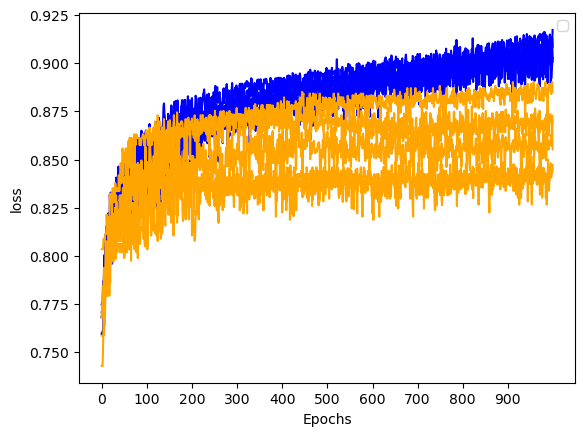

In [1667]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(0, 1000, 100))
plt.ylabel("loss")
plt.legend(loc="upper right")
plt.show()

In [1692]:
#%%capture
from sklearn.preprocessing import OneHotEncoder
DEVICE = torch.device("cpu")

print("Training Model....")
NUM_EPOCHS = 500
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 45
BATCH_SIZE = 128

model = DGCNN(in_channels=NUM_NODE_FEATURES, 
              num_electrodes=NUM_CHANNELS, 
              out_channels=8, 
              num_classes=NUM_CLASSES)

loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_corr_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_corr_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A1, A2, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A1 = A1.float()
        A2 = A2.float()
        y_pred = model(x, A1, A2)
        loss = loss_func(y_pred, y)
        loss_sum += loss#.item()
        loss.backward()
        optimizer.step()

Training Model....


100%|█████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.35it/s]


In [2451]:
train_y.shape

(2232, 1)

In [1665]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A1, A2, y in data_iter:
            x = x.float()
            A1 = A1.float()
            A2 = A2.float()
            yhat = model(x, A1, A2)
            
            #yhat = [0 if i<0.5 else 1 for i in yhat]
            #yhat = torch.exp(yhat)
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    #fpr, tpr, thresholds = roc_curve(ytrue, y_score)
    #auc_measure = auc(fpr, tpr)
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds,  average='weighted'), 
            recall_score(ytrue, ypreds,  average='weighted'),
            f1_score(ytrue, ypreds,  average='weighted'))

In [1693]:
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.900089605734767
Precision:  0.8939365076832771
Recall:  0.900089605734767
F1:  0.8891270303751577
Confusion Matrix:  [[1838   39]
 [ 184  171]]


In [1694]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.7621621621621621
Precision:  0.7623754833057159
Recall:  0.7621621621621621
F1:  0.7619113959320144
Confusion Matrix:  [[75 20]
 [24 66]]


In [ ]:
Accuracy:  0.8108108108108109
Precision:  0.815856875262816
Recall:  0.8108108108108109
F1:  0.8104455913985295
Confusion Matrix:  [[72 23]
                    [12 78]]